# Transformer From Scratch

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb, math
from copy import deepcopy

import numpy as np
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="talk")
%matplotlib inline

import torch;
assert(torch.cuda.is_available())
from torch import nn
from torch.nn import functional as F

In [3]:
from transformer import *

In [4]:
d_model = 10
bs = 3
seq_len = 4
n_heads = 5
d_ff = 5
max_len=11

dropout = 0.5
valid_len = torch.tensor([2,3,2])

x = torch.rand(bs, seq_len, d_model)
# x = torch.ones(bs, seq_len, d_model)
query,key,value = x,x,x

In [97]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout=0., max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(dropout)
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    self.pe = pe.unsqueeze(0)
    
  def forward(self, x):
    # TODO: potential problem with requires_grad
    x = x + self.pe[:, :x.shape[1], :]
    return self.dropout(x)

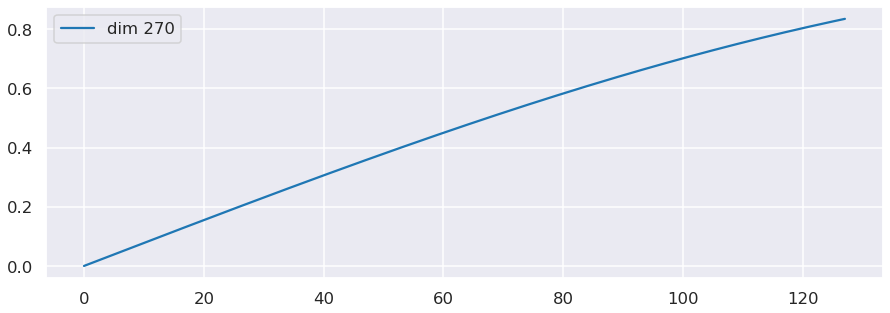

In [134]:
d_model = 512
seq_len = 128
lower = 270
upper = 271
fig, ax = plt.subplots(1,1,figsize=(15,5))
pe = PositionalEncoding(d_model, 0)
y = pe((torch.zeros(1, seq_len, d_model)))
ax.plot(np.arange(seq_len), y[0, :, lower:upper].data.numpy())
ax.legend(["dim %d"%p for p in np.arange(lower,upper)])

array([-0.9222, -0.9988, -0.9597, -0.8208, -0.6062, -0.3436, -0.0607,
        0.2172,  0.4695,  0.6809,  0.8415,  0.9465,  0.9955,  0.9915,
        0.9401,  0.8485,  0.7248,  0.5774,  0.4144,  0.2432])

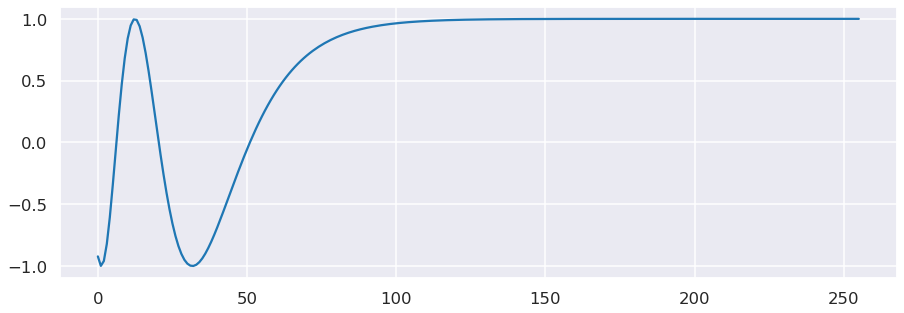

In [185]:
i_s = 10
js = np.arange(1, 512, 2)
y = np.cos(i_s/10000**(js/512))

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(y)
y[:20]

In [ ]:
p

In [78]:
np.cos(np.arange(100)/10000**(21/26))

array([1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
       0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9998, 0.9998,
       0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997,
       0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9996, 0.9996,
       0.9996, 0.9996, 0.9996, 0.9996, 0.9995, 0.9995, 0.9995, 0.9995,
       0.9995, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9993, 0.9993,
       0.9993, 0.9993, 0.9992, 0.9992, 0.9992, 0.9992, 0.9992, 0.9991,
       0.9991, 0.9991, 0.9991, 0.999 , 0.999 , 0.999 , 0.9989, 0.9989,
       0.9989, 0.9989, 0.9988, 0.9988, 0.9988, 0.9988, 0.9987, 0.9987,
       0.9987, 0.9986, 0.9986, 0.9986, 0.9985, 0.9985, 0.9985, 0.9984,
       0.9984, 0.9984, 0.9983, 0.9983])

In [61]:
y[0, :, 7:8]

tensor([], size=(100, 0))

In [7]:
pe = torch.zeros(max_len, d_model)
print(pe)
pe.shape

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


torch.Size([11, 10])

In [8]:
position = torch.arange(0, max_len).unsqueeze(1)
print(position.shape)
position

torch.Size([11, 1])


tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10]])

In [10]:
div_term = torch.exp(-(torch.arange(0, d_model, 2)/d_model) * math.log(10_000))
print(div_term)
div_term.shape

RuntimeError: Integer division of tensors using div or / is no longer supported, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.

In [ ]:
s = torch.sin(position*div_term)
print(s.shape)
s

In [ ]:
c = torch.cos(position*div_term)
print(c.shape)
c

In [ ]:
pe[:, 0::2] = s

In [ ]:
pe[:, 1::2] = c